In [30]:
from __future__ import division
from sys import getsizeof
import gc

import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests 
import scipy.stats as sts

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [31]:
data = pd.read_csv("ab_browser_test.csv")
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [32]:
import math

def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
userID              566134 non-null int64
browser             566134 non-null object
slot                566134 non-null object
n_clicks            566134 non-null int64
n_queries           566134 non-null int64
n_nonclk_queries    566134 non-null int64
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [34]:
data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [35]:
data.browser.unique()

array(['Browser #2', 'Browser #4', 'Browser #14', 'Browser #17',
       'Browser #20', 'Browser #22'], dtype=object)

In [36]:
control =  data[data["slot"]=="control"].copy()
exp = data[data["slot"]== "exp"].copy()

In [37]:
round(abs((control["n_clicks"].sum()-exp["n_clicks"].sum()) / control["n_clicks"].sum())* 100, 3) 

1.614

In [55]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
len(n_boot_samples[1])

10000

In [56]:
np.random.seed(0)

exp_median = np.array(map(np.median, get_bootstrap_samples(exp["n_clicks"].values, 500)))
control_median = np.array(map(np.median, get_bootstrap_samples(control["n_clicks"].values, 500)))

print "95% confidence interval for median",  stat_intervals(control_median-exp_median, 0.05)

95% confidence interval for median [-1. -1.]


In [57]:
np.random.seed(0)

exp_mean = np.array(map(np.mean, get_bootstrap_samples(exp["n_clicks"].values, 500)))
control_mean = np.array(map(np.mean, get_bootstrap_samples(control["n_clicks"].values, 500)))


print "95% confidence interval for  mean",  stat_intervals(control_mean-exp_mean, 0.05)

95% confidence interval for  mean [-0.40496719 -0.19960335]


In [58]:
np.random.seed(0)
n_boot_samples = get_bootstrap_samples(control["n_clicks"].values, 500)

In [42]:
getsizeof(n_boot_samples)/(1024**3)
# del n_boot_samples
# gc.collect()

0.0372530072927475

In [43]:
from multiprocessing import Pool

def n_processing(data):
    n_bs = np.array_split(data, 3)
    
    def pre_proc(n):
        iter_mean = n.mean()
        mse = sum(map(lambda x: (x - iter_mean)**2, n))
        return (iter_mean, mse)
    pool = Pool(3)
    gather_data = pool.map(pre_proc, n_bs)
    pool.close()
    pool.join()

    return gather_data

# control_boot_chi_squared = n_processing(n_boot_samples)
convert_size(getsizeof(n_boot_samples)) 

'38.15 MB'

In [44]:

n_mean = list()
control_boot_chi_squared = list()

for sample in  n_boot_samples:
    iter_mean = sample.mean()
#     var = sample.var()
#     n = sample.shape[0]
    n_mean.append(iter_mean)
    control_boot_chi_squared.append(sum(map(lambda x:  (x - iter_mean)**2, sample)))

(0.20147153668260048, -89.25441040461764, 0.9977575271525095)

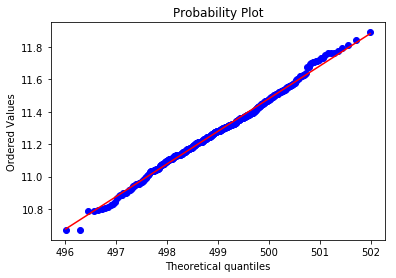

In [45]:
sts.probplot(n_mean, dist="norm", sparams=(len(n_mean)-1), plot=plt)[1]
# show(block=False)

(11284.231661111296, -1514474.8328477093, 0.9867827295447703)

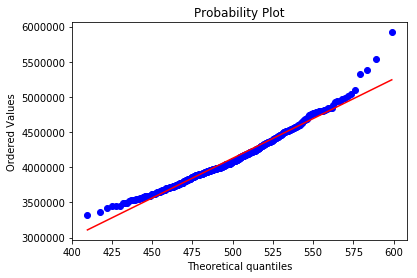

In [46]:
# ??sts.probplot(control_boot_chi_squared, dist="chi2", sparams=(len(control_boot_chi_squared)-1), plot=plt)
sts.probplot(control_boot_chi_squared, dist="chi2", sparams=(len(control_boot_chi_squared)-1), plot=plt)[1]

In [74]:
control_sum = control.groupby('userID')['n_clicks'].agg(np.sum)

In [75]:
exp_sum = exp.groupby('userID')['n_clicks'].agg(np.sum)
exp_sum[:5]

userID
1    23
3     3
5    29
7    54
9     6
Name: n_clicks, dtype: int64

In [76]:
sts.mannwhitneyu(control_sum, exp_sum, use_continuity=True,alternative="two-sided")

MannwhitneyuResult(statistic=38901259929.0, pvalue=8.694294377520879e-75)

In [50]:
browsers = control["browser"].unique()
browser_pvalues = list()
for brws in browsers:
    ctrl_ = control[control["browser"]== brws]["n_clicks"]
    exp_ = exp[exp["browser"]== brws]["n_clicks"]
    browser_pvalues.append(sts.mannwhitneyu(ctrl_, exp_, alternative="two-sided")[1])


In [51]:
mlp_test = zip(control["browser"].unique(), multipletests(browser_pvalues, alpha = 0.05, method = 'bonferroni')[0])
mlp_test

[('Browser #4', False),
 ('Browser #14', True),
 ('Browser #2', False),
 ('Browser #20', False),
 ('Browser #22', False),
 ('Browser #17', False)]

In [52]:
# only one browser - #14 has pronounced difference between control and experiment groups. Looks like new feature effects different only in #14

In [53]:
ctrl_browser_no_clics = list()
exp_browser_no_clics = list()
for brws in browsers:
    overall = control[control["browser"] == brws]["n_queries"].sum()
    ctrl_ = control[control["browser"] == brws]["n_nonclk_queries"].sum()
    exp_ =  exp[exp["browser"]== brws]["n_nonclk_queries"].sum()
    ctrl_browser_no_clics.append(ctrl_ / overall * 100)
    exp_browser_no_clics.append(exp_ / overall * 100)
    

In [54]:
pd.DataFrame({"browser": browsers, "control":ctrl_browser_no_clics, "exp":exp_browser_no_clics})

,browser,control,exp
0,Browser #4,46.970930,43.035490
1,Browser #14,57.590411,44.163173
2,Browser #2,45.962747,43.535327
3,Browser #20,40.540485,37.675998
4,Browser #22,40.593977,38.111396
5,Browser #17,36.299367,37.149927


In [70]:
type(control["userID"].iloc[1])

numpy.int64